# Une représentation des inégalités scolaires










## Préliminaire - Installation des packages nécessaires 

In [ ]:
!pip install pathlib2
!pip install python-Levenshtein
!pip install --upgrade xlrd
!pip install git+https://github.com/InseeFrLab/Py-Insee-Data.git


In [ ]:
import requests
url = 'https://github.com/InseeFrLab/Py-Insee-Data/archive/refs/heads/master.zip'
r = requests.get(url)
with open("pynsee.zip" , 'wb') as zipfile:
    zipfile.write(r.content)


In [ ]:
!pip install --ignore-installed pynsee.zip
!pip install python-Levenshtein
!pip install openpyxl


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pynsee.download
import seaborn as sns

## I - Ouverture et manipulation des bases de données

### A - La base de données sur les résultats par données

On ouvre cette base de données à partir du fichier stocké dans le Datalab.

On s'intéresse d'abord à la feuille contenant les données pour les lycées généraux et technologiques. 
On supprime les colonnes qui ne nous seront pas utiles (sur les taux attendus et les effectifs).

In [ ]:
#file_name = "ival-2021---complet-xlsx-112652.xlsx"
df = pd.read_excel ("ival-2021---complet-xlsx-112652.xlsx", header = [0,1])

fichier_LGT = df.copy()
fichier_LGT = fichier_LGT.drop (["Valeur ajoutée du taux d'accès"], axis = 1)
fichier_LGT = fichier_LGT.drop(["Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus", "Taux de mentions bruts", "Valeur ajoutée de taux de mentions"], axis = 1)

Les données concernant les bacs technologiques étant divisées par filière, nous regroupons toutes les filières sous une colonne technologique. 

On commence par remplacer les valeurs non existantes par des zéros. 
Puis, on calcule le nombre d'élèves présents au bac technologique. 

In [ ]:
fichier_LGT = fichier_LGT.fillna(0)
#fichier.loc[:,("Nombre d'élèves présents au Bac","Somme Pro")] = fichier["Nombre d'élèves présents au Bac", "STMG"] + fichier["Nombre d'élèves présents au Bac", "STI2D"] + fichier["Nombre d'élèves présents au Bac", "STD2A"]+fichier["Nombre d'élèves présents au Bac", "STL"]+df_rose["Nombre d'élèves présents au Bac", "ST2S"]+fichier["Nombre d'élèves présents au Bac", "S2TMD"]+fichier["Nombre d'élèves présents au Bac", "STHR"]#
fichier_LGT.loc[:,("Nombre d'élèves présents au Bac","Somme Techno")] = fichier_LGT["Nombre d'élèves présents au Bac", 'TOTAL']- fichier_LGT["Nombre d'élèves présents au Bac", "GNLE"]
fichier_LGT["Nombre d'élèves présents au Bac"]


On calcule les totaux de taux de réussite bruts pour les filières technologiques. 

In [ ]:
#test = ((fichier_LGT["Taux de réussite bruts", "TOTAL"]*fichier_LGT["Nombre d'élèves présents au Bac", "TOTAL"])-(fichier_LGT["Taux de réussite bruts", "GNLE"]*fichier_LGT["Nombre d'élèves présents au Bac", "GNLE"]))/fichier_LGT["Nombre d'élèves présents au Bac", "Somme Techno"]
#fichier_LGT.loc[(fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"] > 0.5),("Taux de réussite bruts", "Taux brut techno")] = (fichier_LGT["Taux de réussite bruts", "TOTAL"]*fichier_LGT["Nombre d'élèves présents au Bac", "TOTAL"] - fichier_LGT["Taux de réussite bruts", "GNLE"]*fichier_LGT["Nombre d'élèves présents au Bac", "GNLE"])/fichier_LGT["Nombre d'élèves présents au Bac", "Somme Techno"]#
stmg = fichier_LGT["Taux de réussite bruts", "STMG"]*fichier_LGT["Nombre d'élèves présents au Bac", "STMG"]
sti2d = fichier_LGT["Taux de réussite bruts", "STI2D"]*fichier_LGT["Nombre d'élèves présents au Bac", "STI2D"]
std2a = fichier_LGT["Taux de réussite bruts", "STD2A"]*fichier_LGT["Nombre d'élèves présents au Bac", "STD2A"]
stl = fichier_LGT["Taux de réussite bruts", "STL"]*fichier_LGT["Nombre d'élèves présents au Bac", "STL"]
st2s = fichier_LGT["Taux de réussite bruts", "ST2S"]*fichier_LGT["Nombre d'élèves présents au Bac", "ST2S"]
s2tmd = fichier_LGT["Taux de réussite bruts", "S2TMD"]*fichier_LGT["Nombre d'élèves présents au Bac", "S2TMD"]
sthr = fichier_LGT["Taux de réussite bruts", "STHR"]*fichier_LGT["Nombre d'élèves présents au Bac", "STHR"]
taux_tech_brut = (stmg + sti2d + std2a + stl + st2s + s2tmd + sthr)/fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"]


fichier_LGT.loc[(fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"] > 0.5),("Taux de réussite bruts", "Taux brut techno")] = taux_tech_brut #>0.5 pour éviter erreurs d'arrondi de flottants#
fichier_LGT["Taux de réussite bruts"]
#pb avec test à cause des arrondis dans TOTAL (int pas float), résolu avec taux_techno #
#on ne peut pas le faire avec les taux de réussite attendus car on les a enlevé #
#on ne peut pas le faire avec la valeur ajoutée car mauvais type d’objet (on peut en tout cas le faire si besoin à partir du taux attendu et brut si on remet le taux attendu#


On calcule ces mêmes totaux pour les valeurs ajoutées. La difficulté réside dans le format des données dans les colonnes valeur ajoutée.

In [ ]:
#Il faut remplacer les taux non définis par des NaN et transformer en flottant#
liste= ["GNLE", "STMG", "STI2D", "STD2A", "STL", "ST2S", "S2TMD", "STHR", "TOTAL"]
for i in liste:
    fichier_LGT.loc[fichier_LGT["Valeur ajoutée du taux de réussite", i] == "ND", ("Valeur ajoutée du taux de réussite", i)] = np.NaN
    fichier_LGT["Valeur ajoutée du taux de réussite", i] = pd.to_numeric(fichier_LGT["Valeur ajoutée du taux de réussite", i])
fichier_LGT["Valeur ajoutée du taux de réussite"].info()
fichier_LGT["Valeur ajoutée du taux de réussite"]

In [ ]:
#calcul de la valeur ajoutée du taux de réussite pour les bacs techno, reprend tout pour éviter les problèmes d'arrondis#
stmg = fichier_LGT["Valeur ajoutée du taux de réussite", "STMG"]*fichier_LGT["Nombre d'élèves présents au Bac", "STMG"]
sti2d = fichier_LGT["Valeur ajoutée du taux de réussite", "STI2D"]*fichier_LGT["Nombre d'élèves présents au Bac", "STI2D"]
std2a = fichier_LGT["Valeur ajoutée du taux de réussite", "STD2A"]*fichier_LGT["Nombre d'élèves présents au Bac", "STD2A"]
stl = fichier_LGT["Valeur ajoutée du taux de réussite", "STL"]*fichier_LGT["Nombre d'élèves présents au Bac", "STL"]
st2s = fichier_LGT["Valeur ajoutée du taux de réussite", "ST2S"]*fichier_LGT["Nombre d'élèves présents au Bac", "ST2S"]
s2tmd = fichier_LGT["Valeur ajoutée du taux de réussite", "S2TMD"]*fichier_LGT["Nombre d'élèves présents au Bac", "S2TMD"]
sthr = fichier_LGT["Valeur ajoutée du taux de réussite", "STHR"]*fichier_LGT["Nombre d'élèves présents au Bac", "STHR"]
val_aj_tech = (stmg + sti2d + std2a + stl + st2s + s2tmd + sthr)/fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"]


fichier_LGT.loc[(fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"] > 0.5),("Valeur ajoutée du taux de réussite", "Valeur ajoutée techno")] = val_aj_tech #>0.5 pour éviter les problèmes d'arrondis de flottants#
fichier_LGT["Valeur ajoutée du taux de réussite"]

On ré-indexe également la base des lycées généraux et technologiques pour faciliter les manipulations suivantes : nous allons effacer les informations relatives à des filières technologiques spécifiques étant donné qu'on s'intéresse seulement aux bacs technologiques en général.

In [ ]:
fichier_LGT.columns = fichier_LGT.columns.map('_'.join).str.strip('_')
fichier_LGT = fichier_LGT.drop(["Nombre d'élèves présents au Bac_STMG","Nombre d'élèves présents au Bac_STI2D", "Nombre d'élèves présents au Bac_STD2A", "Nombre d'élèves présents au Bac_STL", "Nombre d'élèves présents au Bac_ST2S","Nombre d'élèves présents au Bac_S2TMD", "Nombre d'élèves présents au Bac_STHR", "Taux de réussite bruts_STMG",
"Taux de réussite bruts_STI2D","Taux de réussite bruts_STD2A","Taux de réussite bruts_STL","Taux de réussite bruts_ST2S","Taux de réussite bruts_S2TMD","Taux de réussite bruts_STHR", "Valeur ajoutée du taux de réussite_STMG","Valeur ajoutée du taux de réussite_STI2D","Valeur ajoutée du taux de réussite_STD2A", "Valeur ajoutée du taux de réussite_STL", "Valeur ajoutée du taux de réussite_ST2S", "Valeur ajoutée du taux de réussite_S2TMD", "Valeur ajoutée du taux de réussite_STHR"], axis=1)

On passe ensuite à la feuille concernant les lycées professionnels. Nous avons renommé certaines colonnes afin d'afficher à part les résultats au bac professionnel par rapport aux autres filières lorsqu'on concatènera cette feuille avec celle des lycées généraux et technologiques.

In [ ]:
df2 = pd.read_excel ("ival-2021---complet-xlsx-112652.xlsx", sheet_name = 1, header = [0,1])

fichier_LP = df2.copy()
fichier_LP = fichier_LP.drop (["Valeur ajoutée du taux d'accès", "Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus"], axis = 1)
fichier_LP.columns = fichier_LP.columns.map('_'.join).str.strip('_')
col_cons = ['Informations établissement_Académie', 'Informations établissement_Département', 'Informations établissement_Etablissement', 'Informations établissement_Ville', 'Informations établissement_UAI', 'Informations établissement_Code commune', 'Informations établissement_Secteur', "Nombre d'élèves présents au Bac_TOTAL", 'Taux de réussite bruts_TOTAL', 'Valeur ajoutée du taux de réussite_TOTAL']
fichier_LP = fichier_LP[col_cons]
fichier_LP = fichier_LP.rename(columns={"Nombre d'élèves présents au Bac_TOTAL": "Nombre d'élèves présents au Bac_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Taux de réussite bruts_TOTAL" : "Taux de réussite bruts_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Taux de mentions bruts_TOTAL" : "Taux de mentions bruts_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Valeur ajoutée du taux de réussite_TOTAL" : "Valeur ajoutée du taux de réussite_TOTAL_Pro"})
fichier_LP

Nous allons désormais concaténer les deux feuilles afin d'avoir sur une même DataFrame les informations concernant les baccalauréats généraux, technologiques et professionnels.

In [ ]:
dftotale = pd.concat([fichier_LGT, fichier_LP])
dftotale

Nous allons maintenant procéder au nettoyage d'une base de données regroupant diverses informations sur les communes françaises : nombre d'habitants, de foyers fiscaux, diverses informations sur la répartition des revenus etc...
L'objectif sera de la fusionner avec notre base de données des lycées afin d'associer à chaque lycée le revenu médian de la ville dans laquelle il se situe (et éventuellement d'autres informations à caractère socio-économique). 

Dans un premier temps, nous allons retirer un certain nombre de colonnes qui ne nous intéresse pas. Nous souhaitons simplement garder les informations qui pourront nous permettre de fusionner les bases de données (les codes et libellés), les informations sur la taille des populations et le revenu médian de la commune que nous choisissons comme mesure de la situation économique des habitants. Le reste ne nous sera pas utile.

In [ ]:
df_communes = pd.read_excel("FILO2019_DEC_COM.xlsx", sheet_name = 1, header=[4,5])
df_com = df_communes.copy()
df_com = df_com.drop(['PMIMP19', 'Q119', 'Q319','Q3_Q1','D119', 'D219', 'D319', 'D419', 'D619', 'D719', 'D819', 'D919', 'RD', 'S80S2019', 'GI19', 'PACT19', 'PTSA19', 'PCHO19', 'PBEN19', 'PPEN19', 'PAUT19'], axis = 1, level = 1 )
df_com

Nous allons joindre la DataFrame des lycées et celle des communes pour avoir pour chaque lycée le revenu médian de la ville associée. 

In [ ]:
df_com.columns = df_com.columns.map('_'.join).str.strip('_') #On indexe de manière simple la base de données des communes pour faciliter la jointure
dflyccom = pd.merge(dftotale, df_com, how='left', left_on='Informations établissement_Code commune', right_on='Code géographique_CODGEO')
dflyccom

Etant donné que nous aurons besoin de coordonnées spatiales pour créer des cartes lors de la partie visualisation, nous allons concaténer à notre base de données les coordonnées géographique des établissements scolaires.

Nous allons donc utiliser l'annuaire de l'éducation nationale pour récupérer ces informations en conservant seulement les informations nécessaires pour effectuer la jointure et les données géographiques. Nous réordonnons également les colonnes dans la base de données définitive et renommons les colonnes propres aux filières technologiques et générales afin d'éviter toute confusion. Nous supprimons les colonnes redondantes. 

In [ ]:
geographique = pd.read_excel('fr-en-annuaire-education.xls')   
col_cons = ['Identifiant_de_l_etablissement', 'Code_commune', 'coordonnee_X', 'coordonnee_Y', 'epsg', 'latitude', 'longitude']
geo = geographique[col_cons]

dfdef = dflyccom.merge(geo, how='inner', left_on='Informations établissement_UAI', right_on='Identifiant_de_l_etablissement')
dfdef = dfdef[['Identifiant_de_l_etablissement', 'Informations établissement_Académie','Informations établissement_Département','Informations établissement_Etablissement','Informations établissement_Ville', "Code_commune",
"Informations établissement_Secteur", "Nombre d'élèves présents au Bac_GNLE", "Taux de réussite bruts_GNLE", "Valeur ajoutée du taux de réussite_GNLE", "Nombre d'élèves présents au Bac_Somme Techno",
"Taux de réussite bruts_Taux brut techno", "Valeur ajoutée du taux de réussite_Valeur ajoutée techno", "Nombre d'élèves présents au Bac_TOTAL", "Taux de réussite bruts_TOTAL","Valeur ajoutée du taux de réussite_TOTAL", "Nombre d'élèves présents au Bac_TOTAL_Pro",
"Taux de réussite bruts_TOTAL_Pro","Valeur ajoutée du taux de réussite_TOTAL_Pro", "Nbre de ménages fiscaux_NBMEN19", "Nbre de personnes dans les ménages fiscaux_NBPERS19","Nbre d'unités de consommation dans les ménages fiscaux_NBUC19","Médiane (€)_Q219", "coordonnee_X", "coordonnee_Y",
"epsg", "latitude","longitude" ]]
dfdef = dfdef.rename(columns={"Nombre d'élèves présents au Bac_TOTAL" : "Nombre d'élèves présents au Bac_TOTAL_LGT"})
dfdef = dfdef.rename(columns={"Taux de réussite bruts_TOTAL" : "Taux de réussite bruts_TOTAL_LGT"})
dfdef = dfdef.rename(columns={"Valeur ajoutée du taux de réussite_TOTAL" : "Valeur ajoutée du taux de réussite_TOTAL_LGT"})

Nous allons désormais procéder au nettoyage des données. En effet, des zéros sont présents dans des cases qu'on voudrait ne pas prendre en compte dans notre traitement statistique. Il faut donc les remplacer par des NaN. Par exemple, on voudrait que les lycées qui ne présentent pas de candidats au bac général ne soit pas associé à 0% de taux de réussite étant donné qu'il n'y a aucun élève. 

In [ ]:
dfdef["Nombre d'élèves présents au Bac_GNLE"]= dfdef["Nombre d'élèves présents au Bac_GNLE"].replace(0, np.nan)
dfdef["Nombre d'élèves présents au Bac_Somme Techno"] = dfdef["Nombre d'élèves présents au Bac_Somme Techno"].replace(0, np.nan)
dfdef["Nombre d'élèves présents au Bac_TOTAL_Pro"] = dfdef["Nombre d'élèves présents au Bac_TOTAL_Pro"].replace(0, np.nan)
for i in range(4396):
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_GNLE"])==True: #Si personne ne s'est présenté au bac général
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_GNLE"] = np.nan #On n'associe pas de valeur au taux de réussite brut
        dfdef.loc[dfdef.index[i],"Valeur ajoutée du taux de réussite_GNLE"] = np.nan #On n'associe pas de valeur à la valeur ajoutée du taux de réussite
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_Somme Techno"])==True: #Bac technologique 
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_Taux brut techno"] = np.nan
        dfdef.loc[dfdef.index[i],"Valeur ajoutée du taux de réussite_Valeur ajoutée techno"] = np.nan
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_TOTAL_Pro"])==True: #Bac Pro
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_TOTAL_Pro"] = np.nan
        dfdef.loc[dfdef.index[i], "Valeur ajoutée du taux de réussite_TOTAL_Pro"] =np.nan
dfdef

On enlève aussi les académies d'outre-mer car nous n'avons pas le revenu médian des communes

In [56]:
dfdef_SansDOMTOM = dfdef[dfdef['Informations établissement_Académie']!= 'GUADELOUPE'] 
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!= 'MARTINIQUE']
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!='GUYANE']
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!='MAYOTTE']
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!='LA REUNION']

In [57]:
dfdef.to_excel('base_définitive.xlsx') #On exporte directement cette base de données pour ne pas avoir à relancer toute la manipulation quand on travaille
dfdef_SANSDOMTOM = ('base_def_SansDOMTOM.xlsx') #SansDOMTOM si besoin

## II - Les premières statistiques descriptives

Nous allons effectuer quelques statistiques descriptives sur la base de données que nous venons de créer.
Dans un premier temps, nous allons la récupérer sous la variable qu'on nommera df.

In [63]:
df = pd.read_excel ("base_définitive.xlsx")
df = df.drop("Unnamed: 0", axis=1)

In [64]:
#Quelques Stats Des qu'on va pas nécessairement utiliser à la fin mais au moins ça donne une première idée
df.count() #Ne nous apprend pas grand chose... 
df.mean() #Affiche sous forme scientifique donc pas ouf mais si on sélectionne certaines valeurs ça peut être intéressant
df.quantile(q = [0.1,0.25,0.5,0.75,0.9]) #On peut choisir les quantiles et produire des trucs intéressants
df.describe()
#Je n'envisage pas de conserver cette partie du code, mais c'est pratique de la garder pour copier/coller

/tmp/ipykernel_182/3080630801.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean() #Affiche sous forme scientifique donc pas ouf mais si on sélectionne certaines valeurs ça peut être intéressant
/tmp/ipykernel_182/3080630801.py:4: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.quantile(q = [0.1,0.25,0.5,0.75,0.9]) #On peut choisir les quantiles et produire des trucs intéressants


,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Valeur ajoutée du taux de réussite_GNLE,Nombre d'élèves présents au Bac_Somme Techno,Taux de réussite bruts_Taux brut techno,Valeur ajoutée du taux de réussite_Valeur ajoutée techno,Nombre d'élèves présents au Bac_TOTAL_LGT,Taux de réussite bruts_TOTAL_LGT,Valeur ajoutée du taux de réussite_TOTAL_LGT,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,coordonnee_X,coordonnee_Y,latitude,longitude
count,2113.000000,2113.000000,2110.000000,1760.000000,1760.000000,1716.000000,2261.000000,2261.000000,2258.000000,1948.000000,1948.000000,4209.000000,4209.000000,4209.000000,4209.000000,4.209000e+03,4.209000e+03,4209.000000,4209.000000
mean,173.042120,97.985802,-0.243128,74.481250,95.249092,-0.457656,219.692614,97.329500,-0.279008,79.892197,87.121663,26222.480399,53973.266572,38313.931314,20928.130197,6.750376e+05,6.674955e+06,47.143101,2.653631
std,95.777063,2.423408,2.021257,49.502685,4.836174,4.042250,127.256447,2.967339,2.244890,44.493066,8.828101,35614.792836,70439.760826,50732.172532,5561.488977,2.022445e+05,2.495369e+05,2.249698,2.654397
min,10.000000,80.000000,-15.000000,5.000000,67.000000,-27.000000,20.000000,68.000000,-26.000000,10.000000,20.000000,151.000000,343.000000,243.800000,7800.000000,1.438587e+05,6.076079e+06,41.598662,-4.524620
25%,97.000000,97.000000,-1.000000,34.000000,92.947647,-2.397039,114.000000,96.000000,-1.000000,46.000000,82.000000,5189.000000,11119.000000,7867.900000,17870.000000,5.611178e+05,6.475882e+06,45.362740,1.121640
50%,162.000000,99.000000,0.000000,66.000000,96.158410,0.326007,208.000000,98.000000,0.000000,74.000000,88.000000,12673.000000,27657.000000,19466.100000,19710.000000,6.604946e+05,6.752674e+06,47.804474,2.459480
75%,239.000000,100.000000,1.000000,100.000000,100.000000,2.000000,312.000000,100.000000,1.000000,106.000000,94.000000,29755.000000,63857.000000,44073.900000,22240.000000,8.406388e+05,6.865164e+06,48.881258,4.812210
max,564.000000,100.000000,11.000000,377.000000,100.000000,11.000000,791.000000,100.000000,9.000000,289.000000,100.000000,220888.000000,426072.000000,309944.600000,52570.000000,1.231320e+06,7.105394e+06,51.042674,9.451509


Afin d'appréhender les données pour savoir dans quelle direction partir, nous allons effectuer des statistiques descriptives générales sur notre base de données par rapport aux variables d'intérêt : taux de réussite ainsi que la médiane des revenus des communes.

In [65]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].describe()

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
count,2113.000000,1760.000000,2261.000000,1948.000000,4209.000000
mean,97.985802,95.249092,97.329500,87.121663,20928.130197
std,2.423408,4.836174,2.967339,8.828101,5561.488977
min,80.000000,67.000000,68.000000,20.000000,7800.000000
25%,97.000000,92.947647,96.000000,82.000000,17870.000000
50%,99.000000,96.158410,98.000000,88.000000,19710.000000
75%,100.000000,100.000000,100.000000,94.000000,22240.000000
max,100.000000,100.000000,100.000000,100.000000,52570.000000


Ce premier describe nous permet d'entrevoir quelques données intéressantes. En effet, la répartition des lycées avec des taux de réussites inférieurs à 95% sont répartis en dessous du premier quartile. Cela signifie qu'il existe des établissement en difficultés bien plus lourdes que la moyenne. 
On effectue l'observation inverse pour la médiane des revenus : les écarts ont l'air plus forts dans les déciles supérieurs. Cela montre donc que la corrélation entre revenu et taux de réussite au bac n'est pas parfaite (même si on traitera plus précisément de ces hypothèses lors de la modélisation)
On pourrait essayer d'afficher en observant par déciles afin d'affiner notre observation.

In [66]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].quantile(q = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
0.0,80.0,67.000000,68.0,20.0,7800.0
0.1,95.0,89.000000,94.0,76.0,16232.0
0.2,97.0,91.858637,95.0,80.0,17450.0
0.3,97.0,93.515556,97.0,83.0,18300.0
0.4,98.0,95.000000,97.0,86.0,19090.0
0.5,99.0,96.158410,98.0,88.0,19710.0
0.6,99.0,97.331638,99.0,90.0,20414.0
0.7,100.0,98.807609,99.0,93.0,21460.0
0.8,100.0,100.000000,100.0,95.0,23170.0
0.9,100.0,100.000000,100.0,98.0,27100.0


On se rend compte que les taux de réussite les plus faibles sont dispersés dans le premier décile. 
De même, les revenus médians sont particulièrement dispersés dans le dernier décile. 
Nous allons donc ajouter quelques quantiles pour avoir plus d'information sur la répartition des valeurs extrêmes.

In [67]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].quantile(q = [0, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999,1])

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
0.000,80.000,67.000000,68.0,20.000,7800.0
0.001,83.112,70.277000,78.0,52.947,9990.0
0.010,89.000,79.431938,87.6,62.000,11850.0
0.100,95.000,89.000000,94.0,76.000,16232.0
0.900,100.000,100.000000,100.0,98.000,27100.0
0.990,100.000,100.000000,100.0,100.000,45100.0
0.999,100.000,100.000000,100.0,100.000,52570.0
1.000,100.000,100.000000,100.0,100.000,52570.0


Nous avons désormais une compréhension plus fine de la répartition des valeurs extrêmes. Dans le cas des taux de réussite aux baccalauréats généraux et professionels, on s'aperçoit que leurs minimums est une valeur vraiment extrême car un quantile d'ordre 0.001 prend en compte moins d'une dizaine d'établissement étant donné qu'il y en a moins de 4500 dans l'échantillon total. Pour le bac technologique, on peut faire un constat similaire mais les valeurs extrêmes sont réparties sur le premier percentile. 
Pour les revenus, on s'aperçoit que la dispersion s'effectue bien dans le dernier décile et n'est clairement pas négligeable dans le dernier percentile. 

Cependant, notre analyse ne se concentre pas que sur les taux de réussite au bac. On s'interroge aussi sur les filières dans lesquels les candidats tentent de passer l'examen en fonction du revenu. Tout d'abord, ayons une vue d'ensemble des effectifs.

<BarContainer object of 6 artists>

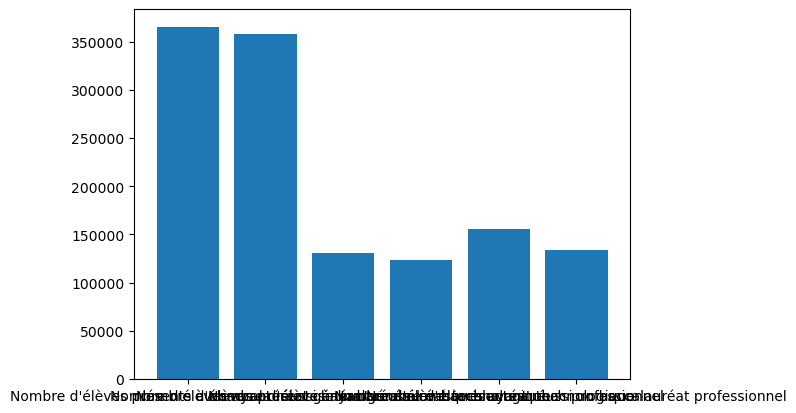

In [68]:
df[["Nombre d'élèves présents au Bac_GNLE","Taux de réussite bruts_GNLE","Nombre d'élèves présents au Bac_Somme Techno","Taux de réussite bruts_Taux brut techno","Nombre d'élèves présents au Bac_TOTAL_Pro","Taux de réussite bruts_TOTAL_Pro"]] 
nbg = df["Nombre d'élèves présents au Bac_GNLE"].sum()
nbgr = np.sum(df["Nombre d'élèves présents au Bac_GNLE"]*df["Taux de réussite bruts_GNLE"])/100
nbt = df["Nombre d'élèves présents au Bac_Somme Techno"].sum()
nbtr = np.sum(df["Nombre d'élèves présents au Bac_Somme Techno"]*df["Taux de réussite bruts_Taux brut techno"])/100
nbp = df["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum()
nbpr = np.sum(df["Nombre d'élèves présents au Bac_TOTAL_Pro"]*df["Taux de réussite bruts_TOTAL_Pro"])/100
plt.bar(["Nombre d'élèves présents au baccalauréat général", "Nombre d'élèves ayant réussi le bac général", "Nombre d'élèves présents à un baccalauréat technologique", "Nombre d'élèves ayant réussi un baccalauréat technologique", "Nombre d'élèves présents au bac professionnel", "Nombre d'élèves ayant réussi un baccalauréat professionnel"],[nbg, nbgr, nbt, nbtr, nbp, nbpr])

<AxesSubplot: ylabel='Informations établissement_Académie'>

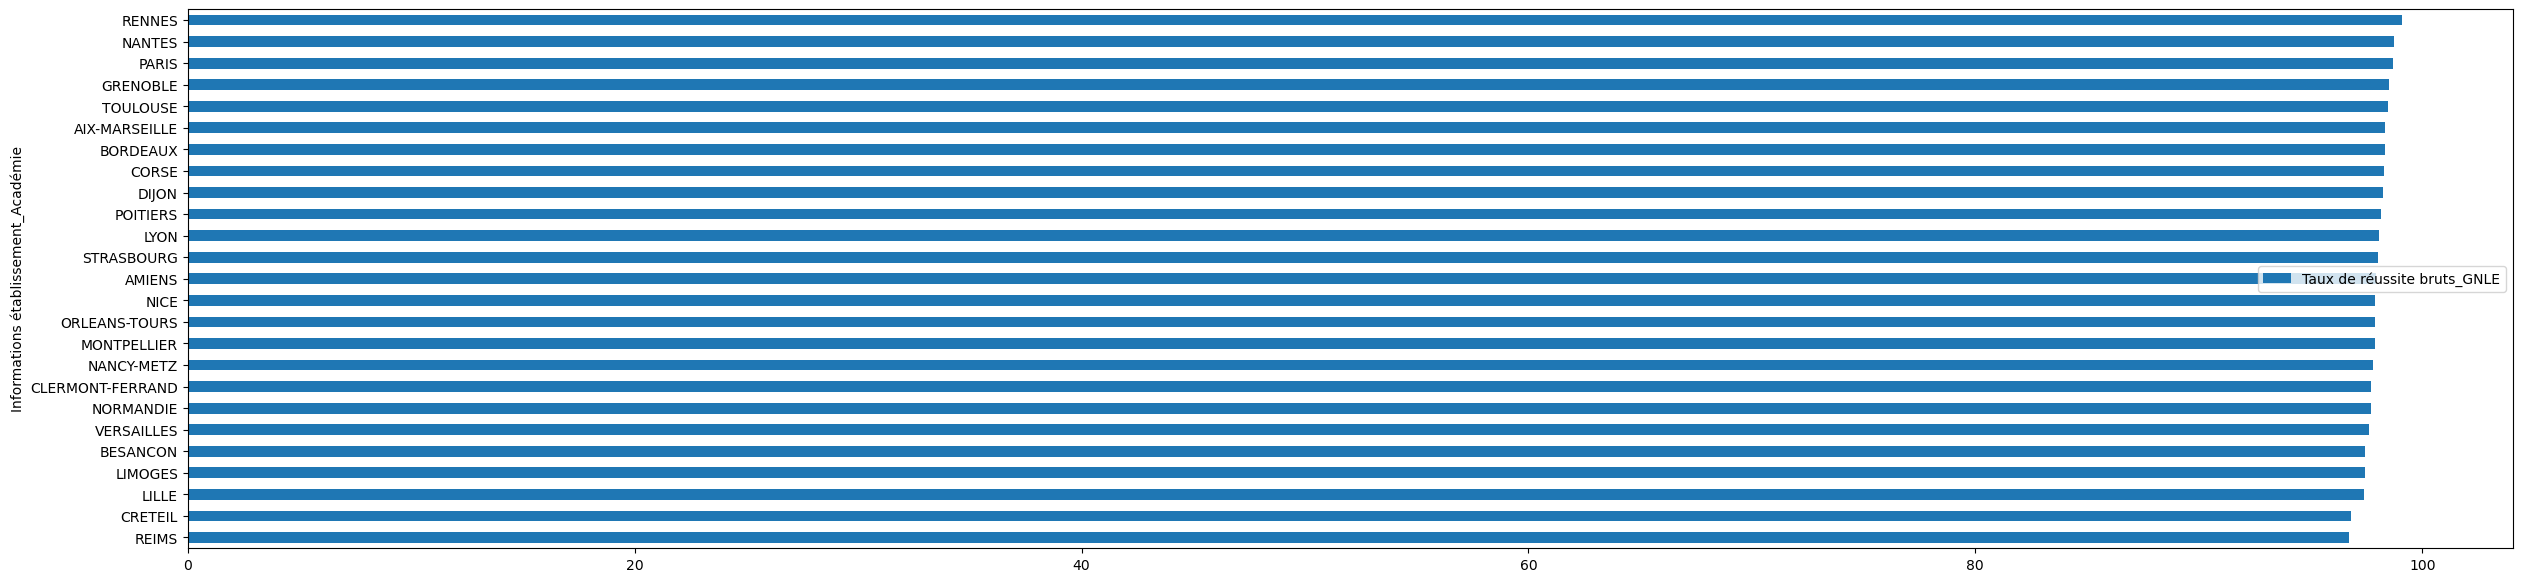

In [69]:
df1 = df.groupby ("Informations établissement_Académie").agg({"Taux de réussite bruts_GNLE":"mean"})
p1 = df1.sort_values ("Taux de réussite bruts_GNLE").plot (kind="barh", figsize = (30,7))
p1

<AxesSubplot: ylabel='Informations établissement_Académie'>

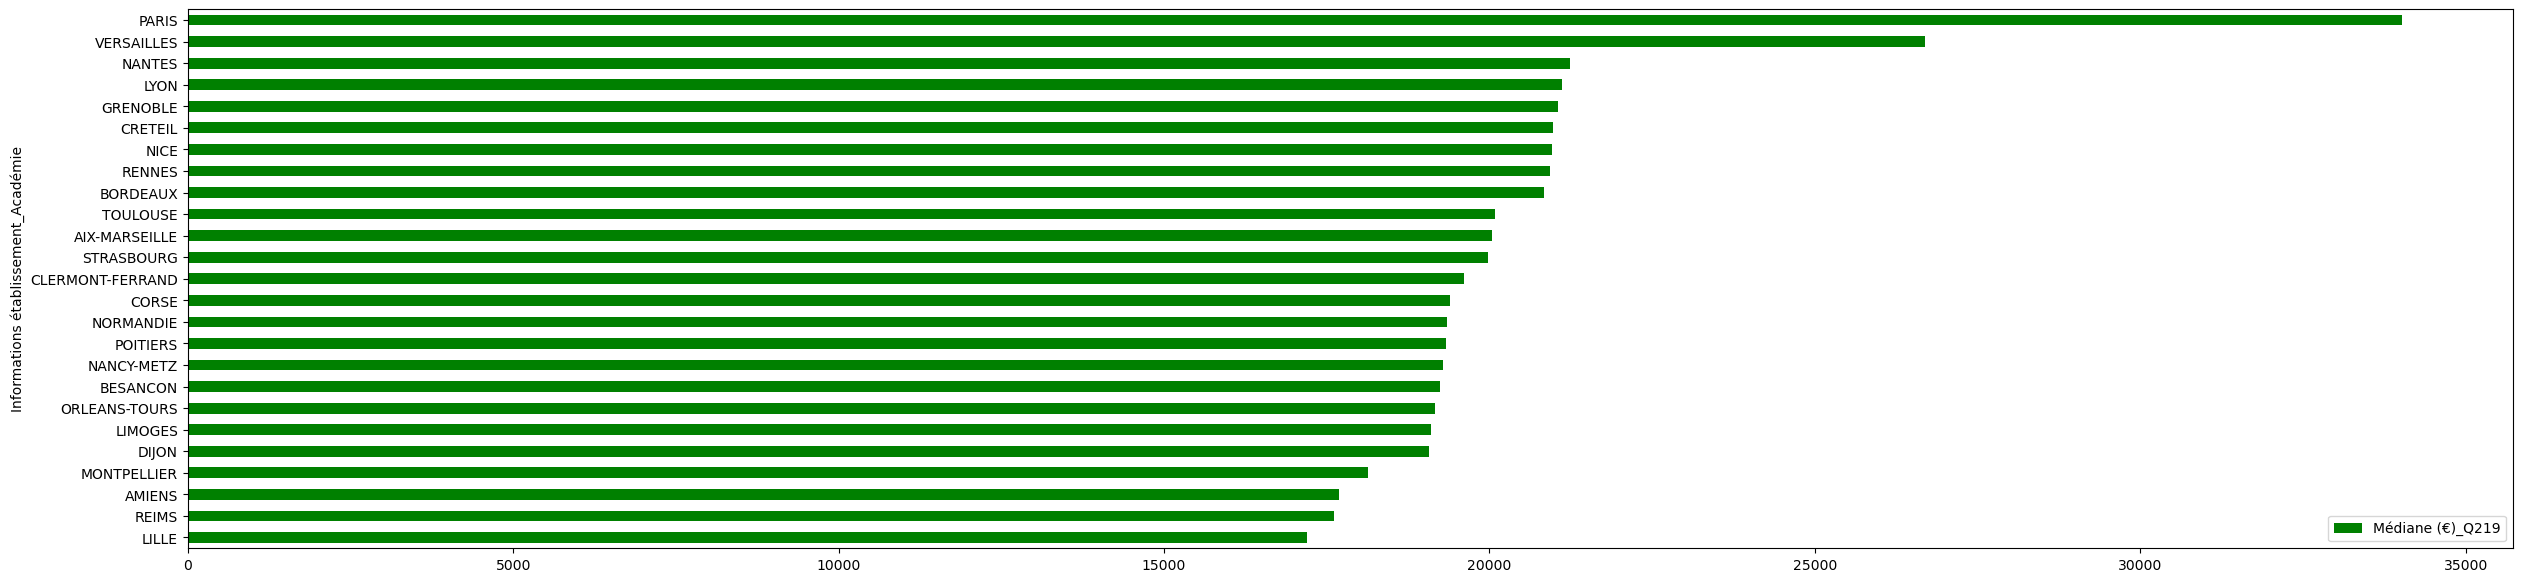

In [70]:
df2 = df.groupby ("Informations établissement_Académie").agg({"Médiane (€)_Q219":"mean"})
p2 = df2.sort_values ("Médiane (€)_Q219").plot (kind="barh", figsize = (30,7), color='green')
p2